## Sparse Signal Recovery


Interested in recovering a sparse signal that has been corrupted by noise that does not follow a (sub)-Gaussian distribution, i.e.
$$
	y = X\beta + \epsilon,
$$
where $\beta$ is the ground truth which is sparse and $\epsilon$ is a noise vector.

Our model is:
$$
\underset{\beta}{\min} \quad \frac{1}{m} \sum_{i=1}^m|x_i^T \beta - y_i| + \lambda \sum_{j=1}^n |\beta_j|.
$$

The first term promotes fitting the data without overfitting to the noisy outliers and the second term induces sparsity in the solution. The parameter $\lambda > 0$ trades off betweent these two goals. In general the "best" $\lambda$ is unknown, so multiple options need to be tried.

The functions in the problem above are piecewise linear, so we need to reformulate into a LP by introducing addition variables, $v$ and $t$.

\begin{align*}
\underset{\beta,t,v}{\min} \quad &\frac{1}{m}\sum_{i=1}^m t_i + \lambda \sum_{j=1}^n v_j \\
\text{s.t.} \quad \ \ &t_i \geq x_i^T \beta - y_i \ \forall i=1,\dots,m \\
&t_i \geq -(x_i^T \beta - y_i) \ \forall i=1,\dots,m \\
&v_j \geq \beta_j \ \forall j=1,\dots,n \\
&v_j \geq -\beta_j \ \forall j=1,\dots,n
\end{align*}

In [1]:
using JuMP
using HiGHS
using Random, Distributions
using LinearAlgebra

#Make sure notebook always produces the same results
Random.seed!(0)

n=10;
m=500;

numsamples = m;

#Well known symmetric, heavy-tailed distribution, see, e.g. https://en.wikipedia.org/wiki/Cauchy_distribution for details.
d = Cauchy()

#Generate a random vector using uniformly at random noise,
#just going to be used to select some indices which will
#be non-zero in our "ground truth" vector
v = rand(Uniform(0,1), n)
#Find the 3 indices with the largest values in v
nonzeros = partialsortperm(v, 1:3)

#Create a vector of 0's
groundtruth = zeros(n)
#For the indices that will be non-zero, give them a random value
for i=1:length(nonzeros)
    groundtruth[nonzeros[i]] = rand(Normal(0,5))
end

#Create a random matrix using the matrix normal distribution
X = rand(MatrixNormal(zeros(m,n), Diagonal(ones(m,m)), Diagonal(ones(n,n))))

#Set the RHS vector be to be A*groundtruth + noise
#(coming from the distribution d) defined above
y = X*groundtruth + 10*rand(d, m)

#Run this with no regularization, regularization parameter of .02,
#regularization parameter of .05 and regularization parameter of .1
lambdas = [0, .02, .05, .1]

βout = zeros(n,length(lambdas))

i = 1
#Run this loop once per regularization parameter λ
#Store the result in a column of xout
for λ in lambdas
    sparse = Model(HiGHS.Optimizer)
    @variable(sparse, β[1:n])
    #Add epigraph variables
    @variable(sparse, t[1:m] >= 0)
    @variable(sparse, v[1:n] >= 0)

    #Add epigraph constraints for the absolute value of x
    @constraint(sparse, epigraph1y[i in 1:m], t[i] >= sum(X[i,j]*β[j] for j in 1:n)-y[i])
    @constraint(sparse, epigraph2y[i in 1:m], t[i] >= -(sum(X[i,j]*β[j] for j in 1:n)-y[i]))

    @constraint(sparse, epigraph1t[i in 1:n], v[i] >= β[i])
    @constraint(sparse, epigraph2t[i in 1:n], v[i] >= -β[i])

    #Objective is least squares + λ*\|x\|_1 (which is handled by the epigraph constraints)
    @objective(sparse, Min, (1/m)*sum(t[i] for i in 1:m) + λ*sum(v[i] for i in 1:n))

    optimize!(sparse);
    βout[:,i] = value.(β)
    i = i+1
end

UndefVarError: UndefVarError: `A` not defined

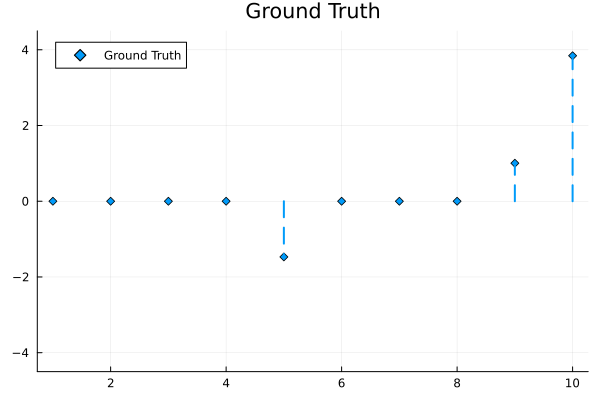

In [2]:
xaxis = 1:n

using Plots

#Plotting the ground truth vector
plot(xaxis, groundtruth, seriestype = :sticks, markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "Ground Truth", ylimits=(-4.5,4.5), label="Ground Truth")

In [3]:
xaxis = 1:n

#Plot the results for different values of λ
#Blue diamonds are the "ground truth", red stars are the solution for that lambda parameter
plot1 = plot(xaxis, groundtruth, seriestype = :sticks, markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 0", ylimits=(-4.5,4.5), label="Ground Truth")
plot1 = plot!(xaxis, βout[:,1], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot, label="Estimate with λ = 0")

UndefVarError: UndefVarError: `βout` not defined

In [4]:
plot2 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = .02", ylimits=(-4.5,4.5), label="Ground Truth")
plot2 = plot!(xaxis, βout[:,2], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot, label="Estimate with λ = 0.02")

UndefVarError: UndefVarError: `βout` not defined

In [5]:
plot3 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = .05", ylimits=(-4.5,4.5), label="Ground Truth")
plot3 = plot!(xaxis, βout[:,3], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot, label="Estimate with λ = 0.05")

UndefVarError: UndefVarError: `βout` not defined

In [6]:
plot3 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = .1", ylimits=(-4.5,4.5), label="Ground Truth")
plot3 = plot!(xaxis, βout[:,4], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot, label="Estimate with λ = 0.1")

UndefVarError: UndefVarError: `βout` not defined